# Introduction
This notebook is target to train a model to identify if a person is wearing a face mask and a safety helmet.

The dataset is small, with 308 images, and around 1800 detected face.

Target trial as below:
1. Try the basic transfer learning using Resnet-18
- No freezing layer
- Freezing Layer
2. Leverage YOLO-v5 for the attempt on training with custome data

In [1]:
# Import basic library
import os
import cv2
import random
import numpy as np
from lxml import etree
from tqdm import tqdm
from PIL import Image
import cv2 
from scipy import stats
import shutil

from IPython.display import display

In [2]:
# Import Library for ResNet
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Annotation extraction and image chop

In [3]:
IMAGE_SRC = '../dataset/images'
ANNOTATION_FILE = '../dataset/annotations.xml'

img_list = [f for f in os.listdir(IMAGE_SRC) if os.path.isfile(os.path.join(IMAGE_SRC, f))]
root = etree.parse(ANNOTATION_FILE).getroot()

dataset = []

for img_name in img_list:
    img = cv2.imread(os.path.join(IMAGE_SRC, img_name))
    img_id = img_name.split('.')[0]
    image_name_attr = ".//image/[@id='{}']".format(img_id)
    for image_tag in root.iterfind(image_name_attr):
        for box_tag in image_tag.iter('box'):
            box = {'image_id': img_id, 'img_name': img_name}
            for key, value in box_tag.items():
                box[key] = round(float(value)) if key in ['xbr', 'xtl', 'ybr', 'ytl'] else value
            box['width'] = float(box['xbr']) - float(box['xtl']) 
            box['height'] = float(box['ybr']) - float(box['ytl'])
            box['cropped_image'] = img[ box['ytl']: box['ybr'], box['xtl']:box['xbr']]
            if box['label'] == 'head':
                for attribute_tag in box_tag.iter('attribute'): 
                    if attribute_tag.attrib['name'] == 'has_safety_helmet':
                        box['helmet_label'] = attribute_tag.text
                    if attribute_tag.attrib['name'] == 'mask':
                        box['mask_label'] = attribute_tag.text
                dataset.append(box)


## Select random sample for exploration

In [4]:
def view_sample(data: dict):
    img = cv2.cvtColor( data['cropped_image'], cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))
    print('Helmet: ', data.get('helmet_label', None))
    print('Mask: ', data.get('mask_label', None))
    print('Image Width - Height: {} {}'.format(data['width'], data['height']))

def sample_picker(dataset, sample_id):
    data = dataset[sample_id] 
    view_sample(data)

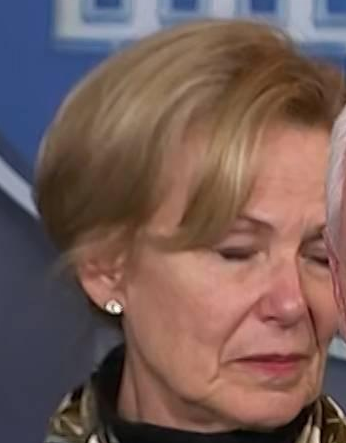

Helmet:  no
Mask:  no
Image Width - Height: 346.0 443.0


In [8]:
sample_picker(dataset, sample_id = random.randint(0, len(dataset)))

# Exploratory Data Analysis

Length of dataset: 1792
Helmet Class distribution: {'yes': 1170, 'no': 622}
Mask Class distribution: {'yes': 494, 'no': 428, 'invisible': 869, 'wrong': 1}


Width DescribeResult(nobs=1792, minmax=(2.0, 1044.0), mean=31.303571428571427, variance=2503.673287070272, skewness=8.227933571175695, kurtosis=116.71127548341272) 

Height DescribeResult(nobs=1792, minmax=(2.0, 1012.0), mean=37.22377232142857, variance=3106.8594457281447, skewness=6.442690011010237, kurtosis=71.04713182089796) 

Ratio DescribeResult(nobs=1792, minmax=(0.5, 3.383177570093458), mean=1.1926839252653214, variance=0.06216621687743987, skewness=1.5830528358306917, kurtosis=9.701898175784155) 

Area DescribeResult(nobs=1792, minmax=(8.0, 1056528.0), mean=3879.4391741071427, variance=859915836.6127135, skewness=27.429987278127957, kurtosis=936.1386429873853) 



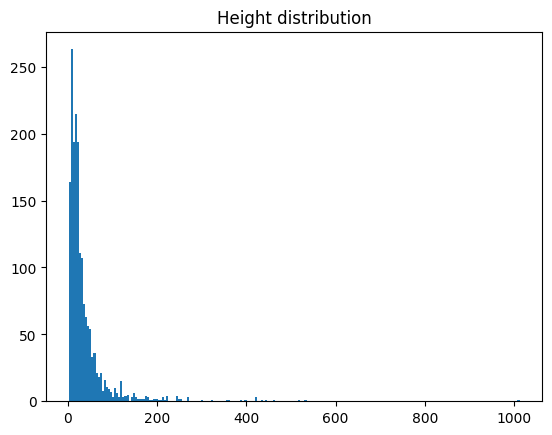

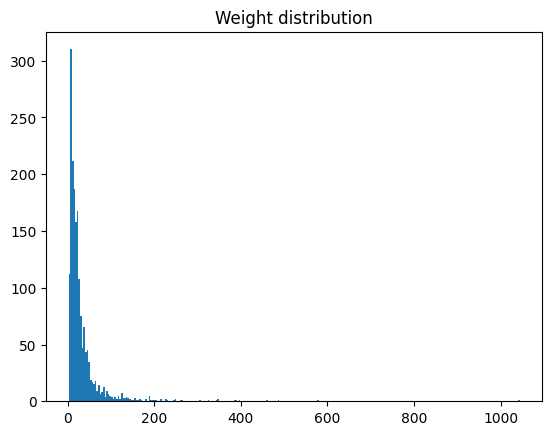

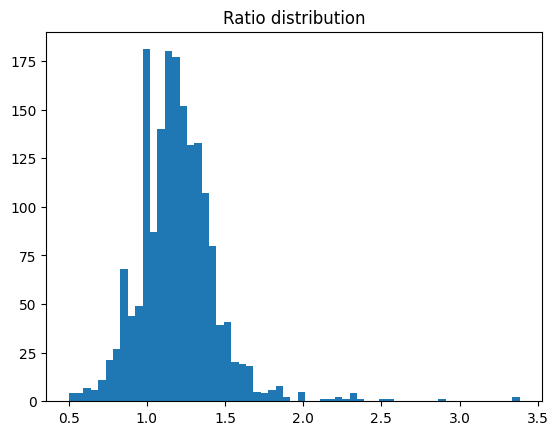

In [9]:
# Length of Dataset
print('Length of dataset: {}'.format(len(dataset)))

# Class distribution
helmet_stat = {}
mask_stat = {}
for data in dataset:
    helmet_stat[data.get('helmet_label', 'None')] = helmet_stat.get(data.get('helmet_label', 'None'), 0) + 1
    mask_stat[data.get('mask_label', 'None')] = mask_stat.get(data.get('mask_label', 'None'), 0) + 1
print('Helmet Class distribution:', helmet_stat)
print('Mask Class distribution:', mask_stat)
print('\n')

# Size distribution
width_list = ([data['width'] for data in dataset])
height_list = ([data['height'] for data in dataset])
hw_scale_list = ([data['height'] /data['width'] for data in dataset])
area_list = ([data['width'] * data['height'] for data in dataset])

print('Width', stats.describe(width_list), "\n")
print('Height', stats.describe(height_list), "\n")
print('Ratio', stats.describe(hw_scale_list), "\n")
print('Area', stats.describe(area_list), "\n")

import matplotlib.pyplot as plt

rng = np.array(height_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Height distribution")
plt.show()

rng = np.array(width_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Weight distribution")
plt.show()


rng = np.array(hw_scale_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Ratio distribution")
plt.show()

## Special Data
A single  label for "Wrong" Mask, remove it for simplicity

wrong


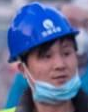

Helmet:  yes
Mask:  wrong
Image Width - Height: 88.0 112.0


In [10]:
special_data = []
for data in dataset:
    if data.get('mask_label', 'None') in [ 'wrong']:
        print(data.get('mask_label', 'None'))
        special_data.append(data)
        view_sample(data)
        dataset.remove(data)


# Data split 

## (Skip first, by overfit the dataset to prove working)

In [8]:
# modes = ['train', 'val', 'test']

# # For helmet data
# PROCESSED_IMAGE_DIR = '..\dataset\processed\helmet'
# for data in dataset:
#         for mode in modes:
#                 directory = os.path.join(PROCESSED_IMAGE_DIR, mode, data['helmet_label'] )
#                 if not os.path.exists(directory):
#                         os.makedirs(directory)
#                 cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])

# # For mask data
# PROCESSED_IMAGE_DIR = '..\dataset\processed\mask'
# for data in dataset:
#         for mode in modes:
#                 directory = os.path.join(PROCESSED_IMAGE_DIR, mode, data['mask_label'] )
#                 if not os.path.exists(directory):
#                         os.makedirs(directory)
#                 cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])       

## Add back train-test split

In [11]:
def train_test_split(dataset, train_ratio:float, validation_ratio:float):
    random.shuffle(dataset)
    train_size = round(len(dataset) * train_ratio)
    validation_size = round(len(dataset) * validation_ratio)
    train_dataset = dataset[:train_size]
    validation_dataset = dataset[train_size:train_size+validation_size]
    test_dataset = dataset[train_size+validation_size:]
    return train_dataset, validation_dataset, test_dataset


In [68]:
train_dataset, validation_dataset, test_dataset = train_test_split(dataset, 0.7, 0.2)
print('train set: {}, validation set: {}, test set: {}'.format(len(train_dataset), len(validation_dataset), len(test_dataset)))

train set: 1254, validation set: 358, test set: 179


In [13]:
splitted_dataset = {'train': train_dataset, 'val': validation_dataset, 'test': test_dataset}
PROCESSED_IMAGE_DIR = '..\dataset\processed'

# Remove the previous processed folder
try:
    shutil.rmtree(PROCESSED_IMAGE_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

for key in splitted_dataset.keys():
        for data in splitted_dataset[key]:
                # Split data for Helmet folder
                directory = os.path.join(PROCESSED_IMAGE_DIR, 'helmet', key, data['helmet_label'] )
                if not os.path.exists(directory):
                        os.makedirs(directory)
                cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])
                # Split data for Mask folder
                directory = os.path.join(PROCESSED_IMAGE_DIR, 'mask', key, data['mask_label'] )
                if not os.path.exists(directory):
                        os.makedirs(directory)
                cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])

In [14]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),    #Too blurred image, remove the random resized crop
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Helmet Model training (Resnet-18)
## Data Cleansing, Transformation, (and Augmentation)

In [104]:
data_dir = '../dataset/processed/helmet'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
helmet_class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

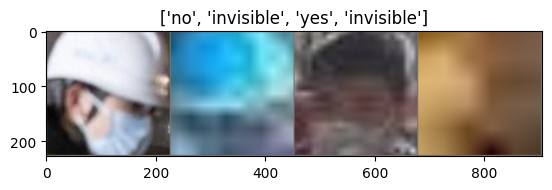

In [99]:
# Get a batch of training data
inputs, helmet_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in helmet_classes])

## Model preparation part

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Transferring Learning from Resnet-18

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_helmet = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


C:\ProgramData\Anaconda3\envs\viact\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.7175 Acc: 0.6874
val Loss: 0.8871 Acc: 0.5670

Epoch 1/24
----------
train Loss: 0.6521 Acc: 0.7249
val Loss: 0.4346 Acc: 0.8101

Epoch 2/24
----------
train Loss: 0.5734 Acc: 0.7608
val Loss: 0.5007 Acc: 0.7709

Epoch 3/24
----------
train Loss: 0.5438 Acc: 0.7711
val Loss: 0.5841 Acc: 0.6983

Epoch 4/24
----------
train Loss: 0.4634 Acc: 0.7951
val Loss: 0.4443 Acc: 0.8240

Epoch 5/24
----------
train Loss: 0.5144 Acc: 0.7823
val Loss: 0.4498 Acc: 0.7821

Epoch 6/24
----------
train Loss: 0.4591 Acc: 0.7990
val Loss: 0.4707 Acc: 0.8073

Epoch 7/24
----------
train Loss: 0.3396 Acc: 0.8469
val Loss: 0.3967 Acc: 0.8045

Epoch 8/24
----------
train Loss: 0.3396 Acc: 0.8581
val Loss: 0.3800 Acc: 0.8073

Epoch 9/24
----------
train Loss: 0.3716 Acc: 0.8533
val Loss: 0.3944 Acc: 0.7933

Epoch 10/24
----------
train Loss: 0.3185 Acc: 0.8820
val Loss: 0.3927 Acc: 0.8045

Epoch 11/24
----------
train Loss: 0.3630 Acc: 0.8525
val Loss: 0.3646 Acc: 0.8240

Epoch 12/24
----------
t

In [47]:
MODEL_OUTPUT_PATH = '..\output'
torch.save(model_ft.state_dict(), os.path.join(MODEL_OUTPUT_PATH, 'helmet_resnet'))

## Freeze the COV net layer

In [45]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [46]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6700 Acc: 0.6555
val Loss: 0.5294 Acc: 0.7179

Epoch 1/24
----------
train Loss: 0.6503 Acc: 0.6874
val Loss: 0.5355 Acc: 0.7207

Epoch 2/24
----------
train Loss: 0.6856 Acc: 0.6922
val Loss: 0.5302 Acc: 0.7514

Epoch 3/24
----------
train Loss: 0.6386 Acc: 0.7217
val Loss: 0.8413 Acc: 0.6285

Epoch 4/24
----------
train Loss: 0.6319 Acc: 0.7289
val Loss: 0.5081 Acc: 0.7430

Epoch 5/24
----------
train Loss: 0.6416 Acc: 0.7129
val Loss: 0.7255 Acc: 0.6480

Epoch 6/24
----------
train Loss: 0.7182 Acc: 0.6986
val Loss: 0.5175 Acc: 0.7318

Epoch 7/24
----------
train Loss: 0.5123 Acc: 0.7671
val Loss: 0.5674 Acc: 0.7430

Epoch 8/24
----------
train Loss: 0.5107 Acc: 0.7616
val Loss: 0.5499 Acc: 0.7318

Epoch 9/24
----------
train Loss: 0.5294 Acc: 0.7568
val Loss: 0.5148 Acc: 0.7514

Epoch 10/24
----------
train Loss: 0.5016 Acc: 0.7512
val Loss: 0.5028 Acc: 0.7458

Epoch 11/24
----------
train Loss: 0.5241 Acc: 0.7719
val Loss: 0.5184 Acc: 0.7430

Ep

# Mask Model

In [103]:
data_dir = '../dataset/processed/mask'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
mask_class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

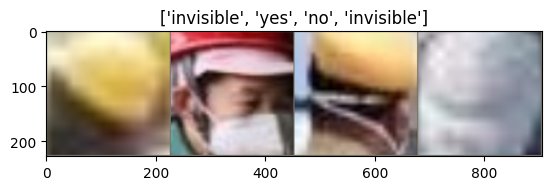

In [96]:
# Get a batch of training data
inputs, mask_classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in mask_classes])

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
model_mask = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0557 Acc: 0.5686
val Loss: 0.9241 Acc: 0.6313

Epoch 1/24
----------
train Loss: 1.1523 Acc: 0.5694
val Loss: 0.8284 Acc: 0.6676

Epoch 2/24
----------
train Loss: 0.9771 Acc: 0.6252
val Loss: 0.9587 Acc: 0.6061

Epoch 3/24
----------
train Loss: 0.9105 Acc: 0.6380
val Loss: 0.8044 Acc: 0.6620

Epoch 4/24
----------
train Loss: 0.8758 Acc: 0.6675
val Loss: 0.7351 Acc: 0.7235

Epoch 5/24
----------
train Loss: 0.8250 Acc: 0.6715
val Loss: 1.0432 Acc: 0.5028

Epoch 6/24
----------
train Loss: 0.8184 Acc: 0.6818
val Loss: 0.7370 Acc: 0.7067

Epoch 7/24
----------
train Loss: 0.6377 Acc: 0.7520
val Loss: 0.6663 Acc: 0.7263

Epoch 8/24
----------
train Loss: 0.5968 Acc: 0.7624
val Loss: 0.6573 Acc: 0.7263

Epoch 9/24
----------
train Loss: 0.5734 Acc: 0.7751
val Loss: 0.6755 Acc: 0.7402

Epoch 10/24
----------
train Loss: 0.5396 Acc: 0.8006
val Loss: 0.6820 Acc: 0.7207

Epoch 11/24
----------
train Loss: 0.4864 Acc: 0.8174
val Loss: 0.6970 Acc: 0.7207

Ep

In [30]:
MODEL_OUTPUT_PATH = '..\output'
torch.save(model_mask.state_dict(), os.path.join(MODEL_OUTPUT_PATH, 'mask_resnet'))

# Inference Pipeline

In [117]:
model_helmet.eval() 
model_mask.eval() 
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for test_data in test_dataset:
    test_record = test_transform(Image.fromarray(test_data['cropped_image'])).unsqueeze(0)
    _, preds = torch.max(model_helmet(test_record.to(device)), 1)
    test_data['helmet_prediction'] = helmet_class_names[preds]
    # print(helmet_class_names[preds] , test_data['helmet_label'])

    test_record = test_transform(Image.fromarray(test_data['cropped_image'])).unsqueeze(0)
    _, preds = torch.max(model_mask(test_record.to(device)), 1)
    test_data['mask_prediction'] = mask_class_names[preds]
    # print(mask_class_names[preds] , test_data['mask_label'])

## Test Evaluation Result

### Accuracy

In [121]:
# mask correct 
mask_accuracy = np.sum([1 if data['mask_prediction'] == data['mask_label'] else 0 for data in test_dataset])/len(test_dataset)

# helmet correct 
helmet_accuracy = np.sum([1 if data['helmet_prediction'] == data['helmet_label'] else 0 for data in test_dataset])/len(test_dataset)

# both correct 
combined_accuracy = np.sum([1 if data['helmet_prediction'] == data['helmet_label'] and data['mask_prediction'] == data['mask_label'] else 0 for data in test_dataset])/len(test_dataset)

print('Mask Accuracy = {}, Helmet Accuracy = {}, Combined Accuracy = {}'.format(mask_accuracy, helmet_accuracy, combined_accuracy))

Mask Accuracy = 0.6871508379888268, Helmet Accuracy = 0.8547486033519553, Combined Accuracy = 0.5810055865921788


### Precision and Recall (on label 'yes')

In [130]:
def f1_score(recall, precision):
   return 2 * recall * precision / (recall + precision)

mask_TP_arr = [1 if data['mask_prediction'] == 'yes' and data['mask_label'] == 'yes'else 0 for data in test_dataset]
mask_PP_arr = [1 if data['mask_prediction'] == 'yes'else 0 for data in test_dataset]  
mask_P_arr = [1 if data['mask_label'] == 'yes'else 0 for data in test_dataset]  
mask_precision = np.sum(mask_TP_arr)/np.sum(mask_PP_arr)
mask_recall = np.sum(mask_TP_arr)/np.sum(mask_P_arr)

helmet_TP_arr = [1 if data['helmet_prediction'] == 'yes' and data['helmet_label'] == 'yes'else 0 for data in test_dataset]
helmet_PP_arr = [1 if data['helmet_prediction'] == 'yes'else 0 for data in test_dataset]
helmet_P_arr = [1 if data['helmet_label'] == 'yes'else 0 for data in test_dataset]
helmet_precision = np.sum(helmet_TP_arr)/np.sum(helmet_PP_arr)
helmet_recall = np.sum(helmet_TP_arr)/np.sum(helmet_P_arr)

combined_TP_arr = [1 if data['helmet_prediction'] == 'yes' and data['helmet_label'] == 'yes' and 
                        data['mask_prediction'] == 'yes' and data['mask_label'] == 'yes' 
                     else 0 for data in test_dataset]
combined_PP_arr = [1 if data['helmet_prediction'] == 'yes' and data['mask_prediction'] == 'yes'else 0 for data in test_dataset]
combined_P_arr = [1 if data['helmet_label'] == 'yes' and data['mask_label'] == 'yes'else 0 for data in test_dataset]
combined_precision = np.sum(combined_TP_arr)/np.sum(combined_PP_arr)
combined_recall = np.sum(combined_TP_arr)/np.sum(combined_P_arr)

mask_F1 = f1_score(mask_recall, mask_precision)
helmet_F1 = f1_score(helmet_recall, helmet_precision)
combined_F1 = f1_score(combined_recall, combined_precision)


print('Mask Precision = {}, Helmet Precision = {}, Combined Precision = {}'.format(mask_precision, helmet_precision, combined_precision))
print('Mask Recall = {}, Helmet Recall = {}, Combined Recall = {}'.format(mask_recall, helmet_recall, combined_recall))
print('Mask F1 = {}, Helmet F1 = {}, Combined F1 = {}'.format(mask_F1, helmet_F1, combined_F1))


Mask Precision = 0.6875, Helmet Precision = 0.8582089552238806, Combined Precision = 0.75
Mask Recall = 0.46808510638297873, Helmet Recall = 0.9426229508196722, Combined Recall = 0.45
Mask F1 = 0.5569620253164557, Helmet F1 = 0.8984375000000001, Combined F1 = 0.5625000000000001
